# Burocracias
---

In [ ]:
%pip install -r requirements.txt

In [1]:
from ucimlrepo import fetch_ucirepo # https://archive.ics.uci.edu/dataset/10/automobile

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split


#import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense,Dropout
from keras.optimizers import SGD

# import funcoes_auxiliares as faux
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Funções Auxiliares
---

In [2]:
def busca_registros_faltantes(df):
    # Verifica quais colunas têm pelo menos um dado faltante
    colunas_com_faltantes = df.columns[df.isnull().any()]

    # Filtra o dataframe original para incluir apenas as colunas com faltantes
    subdataframe = df[colunas_com_faltantes]

    # Verifica quais linhas têm pelo menos um dado faltante no subdataframe
    linhas_com_faltantes = subdataframe.index[subdataframe.isnull().any(axis=1)]

    # Filtra novamente o subdataframe para incluir apenas as linhas com faltantes
    subdataframe = subdataframe.loc[linhas_com_faltantes]

    return subdataframe

def plot_historico(history, title):

  fig, ax = plt.subplots(1,2,figsize=(26,10))

  # Imprime a curva de aprendizado
  ax[0].set_title('Mean Absolute Percentage Error', pad=-40)
  ax[0].plot(history.history['loss'], label='train')
  ax[0].plot(history.history['val_loss'], label='valid')
  ax[0].legend(loc='best')

  # Imprime a curva de acurácia
  ax[1].set_title('Mean Absolute Error', pad=-40)
  ax[1].plot(history.history['mae'], label='train')
  ax[1].plot(history.history['val_mae'], label='valid')
  ax[1].legend(loc='best')

  fig.suptitle(title)

  #fig.savefig('/content/gdrive/MyDrive/Engenharia Elétrica/Deep Learning/' + title)
  #plt.show()

# Pre Processamento
---

In [3]:
# fetch dataset
automobile = fetch_ucirepo(id=10)

# obtem o objeto dataset
dataset = automobile.data.features

# convert to dataframe
dataset = pd.DataFrame(dataset)

# Uma descrição estatística dos dados
dataset.describe()

,price,highway-mpg,city-mpg,peak-rpm,horsepower,compression-ratio,stroke,bore,engine-size,num-of-cylinders,curb-weight,height,width,length,wheel-base,num-of-doors,normalized-losses
count,201.000000,205.000000,205.000000,203.000000,203.000000,205.000000,201.000000,201.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,203.000000,164.000000
mean,13207.129353,30.751220,25.219512,5125.369458,104.256158,10.142537,3.255423,3.329751,126.907317,4.380488,2555.565854,53.724878,65.907805,174.049268,98.756585,3.123153,122.000000
std,7947.066342,6.886443,6.542142,479.334560,39.714369,3.972040,0.316717,0.273539,41.642693,1.080854,520.680204,2.443522,2.145204,12.337289,6.021776,0.994841,35.442168
min,5118.000000,16.000000,13.000000,4150.000000,48.000000,7.000000,2.070000,2.540000,61.000000,2.000000,1488.000000,47.800000,60.300000,141.100000,86.600000,2.000000,65.000000
25%,7775.000000,25.000000,19.000000,4800.000000,70.000000,8.600000,3.110000,3.150000,97.000000,4.000000,2145.000000,52.000000,64.100000,166.300000,94.500000,2.000000,94.000000
50%,10295.000000,30.000000,24.000000,5200.000000,95.000000,9.000000,3.290000,3.310000,120.000000,4.000000,2414.000000,54.100000,65.500000,173.200000,97.000000,4.000000,115.000000
75%,16500.000000,34.000000,30.000000,5500.000000,116.000000,9.400000,3.410000,3.590000,141.000000,4.000000,2935.000000,55.500000,66.900000,183.100000,102.400000,4.000000,150.000000
max,45400.000000,54.000000,49.000000,6600.000000,288.000000,23.000000,4.170000,3.940000,326.000000,12.000000,4066.000000,59.800000,72.300000,208.100000,120.900000,4.000000,256.000000


Com o método 'describe' da biblioteca Pandas, temos a informação "count" para cada coluna. Nela podemos ver que algumas das colunas não possuem todos os valores. O atributo 'normalized losses' está com (205-164) 41 itens faltantes. Considerando que este atributo representa o custo normalizado que as seguradoras tem com o carro, pode-se concluir que não há muita relação com o valor do carro — talvez fosse inversamente proporcional, visto que carros mais caros tendem a dar mais prejuízo as seguradoras. 

De maneira geral, esse é um atributo que certamente terá pouca relevância no valor do carro. Como há muitas dados faltantes, droparei a coluna inteira. Já os atributos: 'peak-rpm', 'horsepower', 'stroke', 'bore' e 'num-of-doors' possuem poucos valores faltantes. Nesses casos, optarei por por fazer uma análise mais detalhada do que exatamente está faltando pois são características e dimensões que tem impacto no custo do carro e se possível gostaria de mante-las no dataset.

In [4]:
# drop price and normalized-losses from features
dataset = dataset.drop(['normalized-losses'], axis=1)
busca_registros_faltantes(dataset)

,price,peak-rpm,horsepower,stroke,bore,num-of-doors
9,NaN,5500.0,160.0,3.40,3.13,2.0
27,8558.0,5500.0,102.0,3.39,3.03,NaN
44,NaN,5400.0,70.0,3.11,3.03,2.0
45,NaN,5400.0,70.0,3.11,3.03,4.0
55,10945.0,6000.0,101.0,NaN,NaN,2.0
56,11845.0,6000.0,101.0,NaN,NaN,2.0
57,13645.0,6000.0,101.0,NaN,NaN,2.0
58,15645.0,6000.0,135.0,NaN,NaN,2.0
63,10795.0,4650.0,64.0,3.39,3.39,NaN
129,NaN,5750.0,288.0,3.11,3.94,2.0


Usando a função auxiliar 'busca_registros_faltantes', produzimos um subdataframe que conserva somente linhas e colunas que possuem pelo menos um dado faltante. Assim, podemos ver que não é de todo o mal. Como disse, vou optar por retirar somente as linhas com dados faltantes objetivando manter o máximo de dados no dataset.

In [5]:
# Índices das linhas que você deseja remover
indices_para_remover = [9, 27, 44, 45, 55, 56, 57, 58, 63, 129, 130, 131]

# Use o método drop() para remover as linhas especificadas
dataset = dataset.drop(indices_para_remover)

In [6]:
dataset.describe()

,price,highway-mpg,city-mpg,peak-rpm,horsepower,compression-ratio,stroke,bore,engine-size,num-of-cylinders,curb-weight,height,width,length,wheel-base,num-of-doors
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,13285.025907,30.787565,25.326425,5099.740933,103.481865,10.143627,3.248860,3.330622,128.124352,4.419689,2561.507772,53.869948,65.893782,174.326425,98.923834,3.160622
std,8089.082886,6.816910,6.387828,468.694369,37.960107,3.977491,0.315421,0.272385,41.590452,1.023182,526.700026,2.394770,2.137795,12.478593,6.152409,0.989583
min,5118.000000,16.000000,13.000000,4150.000000,48.000000,7.000000,2.070000,2.540000,61.000000,3.000000,1488.000000,47.800000,60.300000,141.100000,86.600000,2.000000
25%,7738.000000,25.000000,19.000000,4800.000000,70.000000,8.500000,3.110000,3.150000,98.000000,4.000000,2145.000000,52.000000,64.100000,166.300000,94.500000,2.000000
50%,10245.000000,30.000000,25.000000,5100.000000,95.000000,9.000000,3.290000,3.310000,120.000000,4.000000,2414.000000,54.100000,65.400000,173.200000,97.000000,4.000000
75%,16515.000000,34.000000,30.000000,5500.000000,116.000000,9.400000,3.410000,3.590000,146.000000,4.000000,2952.000000,55.700000,66.900000,184.600000,102.400000,4.000000
max,45400.000000,54.000000,49.000000,6600.000000,262.000000,23.000000,4.170000,3.940000,326.000000,12.000000,4066.000000,59.800000,72.000000,208.100000,120.900000,4.000000


## Verificando correlação

Apesar de querer manter o máximo de dados possível, é uma boa pedida fazer a análise de correlação pois queremos manter somente os atributos que tem relevância no preço. Definirei um ponto de corte para correlação de $\pm0.6$. Deixarei ela parametrizada para que possa ser facilmente modificada.

A Correlação de Pearson é uma métrica muito utilizada para saber o quanto que uma variável numérica interfere ou é inteferida por outra variável de forma linear. E quanto que a correlação de Spearman é utilizada para casos não lineares. Aplicaremos as duas.

Antes de mais nada, precisamos verificar as estruturas de dados do dataset visto que os métodos de correlação só podem ser feitos com valores *numéricos*.

In [7]:
# Supondo que você tenha um DataFrame chamado 'dataset'
print(dataset.dtypes)

price                float64
highway-mpg            int64
city-mpg               int64
peak-rpm             float64
horsepower           float64
compression-ratio    float64
stroke               float64
bore                 float64
fuel-system           object
engine-size            int64
num-of-cylinders       int64
engine-type           object
curb-weight            int64
height               float64
width                float64
length               float64
wheel-base           float64
engine-location       object
drive-wheels          object
body-style            object
num-of-doors         float64
aspiration            object
fuel-type             object
make                  object
dtype: object


Para resolver os atributos são que são categorias, usaremos o *'Label encoding'*.

In [8]:
# Lista das colunas que você deseja codificar
colunas_para_codificar = ['fuel-system', 'engine-type', 'engine-location','drive-wheels', 'body-style', 'aspiration', 'fuel-type', 'make']

# Crie um objeto LabelEncoder
label_encoder = LabelEncoder()

# Itere pelas colunas e aplique o Label Encoding
for coluna in colunas_para_codificar:
    dataset[coluna] = label_encoder.fit_transform(dataset[coluna])

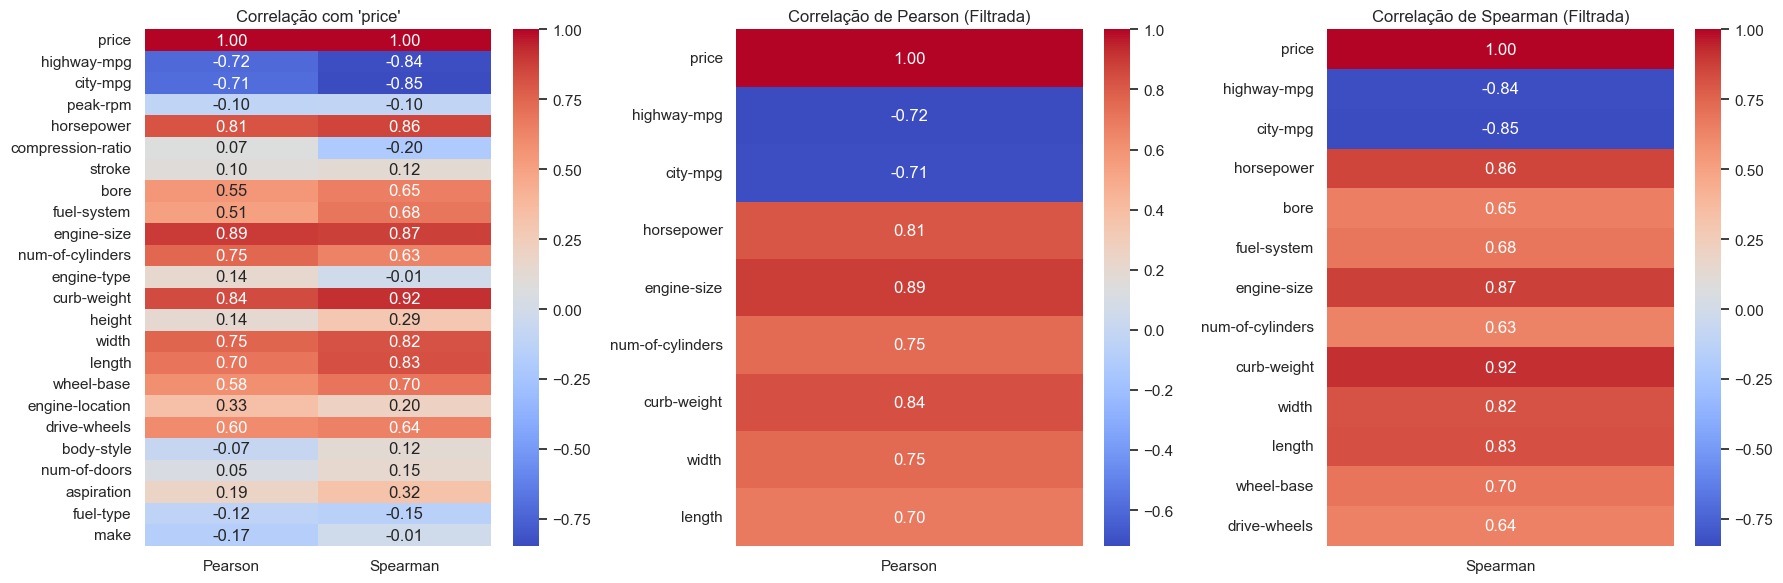

In [9]:
# Correlação de Pearson
pearson = dataset.corrwith(dataset['price'], method='pearson')

# Correlação de Spearman
spearman = dataset.corrwith(dataset['price'], method='spearman')

# Escolha um valor de corte (0.6 no exemplo)
limiar = 0.6

# Mantenha apenas as colunas que atendem ao critério de correlação para Pearson
colunas_pearson_selecionadas = pearson[(pearson >= limiar) | (pearson <= -limiar)].index

# Mantenha apenas as colunas que atendem ao critério de correlação para Spearman
colunas_spearman_selecionadas = spearman[(spearman >= limiar) | (spearman <= -limiar)].index

# Crie um DataFrame com as correlações
correlations = pd.DataFrame({'Pearson': pearson, 'Spearman': spearman})

# Crie um mapa de calor com as correlações originais
sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(data=correlations, annot=True, cmap='coolwarm', fmt=".2f", ax=ax[0])
ax[0].set_title("Correlação com 'price'")

# Crie novos DataFrames com as colunas selecionadas
dataset_pearson_filtrado = dataset[colunas_pearson_selecionadas]
dataset_spearman_filtrado = dataset[colunas_spearman_selecionadas]

# Calcule as correlações para os DataFrames filtrados
pearson_filtrado = dataset_pearson_filtrado.corrwith(dataset['price'], method='pearson')
spearman_filtrado = dataset_spearman_filtrado.corrwith(dataset['price'], method='spearman')

# Crie mapas de calor para as correlações filtradas
sns.heatmap(data=pd.DataFrame({'Pearson': pearson_filtrado}), annot=True, cmap='coolwarm', fmt=".2f", ax=ax[1])
ax[1].set_title("Correlação de Pearson (Filtrada)")

sns.heatmap(data=pd.DataFrame({'Spearman': spearman_filtrado}), annot=True, cmap='coolwarm', fmt=".2f", ax=ax[2])
ax[2].set_title("Correlação de Spearman (Filtrada)")

plt.tight_layout()
plt.show()

Dito isso, não há mais conversa. Seguindo a correlação de Spearman, manteremos as colunas demonstradas.

In [10]:
# Lista de colunas que deseja manter
colunas_desejadas = ['price', 'highway-mpg', 'city-mpg', 'horsepower', 'bore', 'fuel-system', 'engine-size', 'num-of-cylinders', 'curb-weight','width', 'length', 'wheel-base', 'drive-wheels']

# Sobrescreva o dataset com as colunas desejadas
dataset_filtrado = dataset[colunas_desejadas]

dataset_filtrado.describe()

,price,highway-mpg,city-mpg,horsepower,bore,fuel-system,engine-size,num-of-cylinders,curb-weight,width,length,wheel-base,drive-wheels
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,13285.025907,30.787565,25.326425,103.481865,3.330622,2.632124,128.124352,4.419689,2561.507772,65.893782,174.326425,98.923834,1.326425
std,8089.082886,6.816910,6.387828,37.960107,0.272385,1.582589,41.590452,1.023182,526.700026,2.137795,12.478593,6.152409,0.551679
min,5118.000000,16.000000,13.000000,48.000000,2.540000,0.000000,61.000000,3.000000,1488.000000,60.300000,141.100000,86.600000,0.000000
25%,7738.000000,25.000000,19.000000,70.000000,3.150000,1.000000,98.000000,4.000000,2145.000000,64.100000,166.300000,94.500000,1.000000
50%,10245.000000,30.000000,25.000000,95.000000,3.310000,4.000000,120.000000,4.000000,2414.000000,65.400000,173.200000,97.000000,1.000000
75%,16515.000000,34.000000,30.000000,116.000000,3.590000,4.000000,146.000000,4.000000,2952.000000,66.900000,184.600000,102.400000,2.000000
max,45400.000000,54.000000,49.000000,262.000000,3.940000,6.000000,326.000000,12.000000,4066.000000,72.000000,208.100000,120.900000,2.000000


## Transformação dos dados

Agora, podemos normalizar os dados para obter máxima qualidade do modelo. A normalização irá garantir que todos os dados trabalham em um range compatível uns com os outros, isso evita que valores muito altos influenciem erroneamente no modelo. 

> É importante lembrar que alguns dos dados **estão codificados e devem ser retirados da normalização**.

In [11]:
# Identifique as colunas codificadas
colunas_codificadas = ['price','fuel-system','drive-wheels']

# Copie o DataFrame original para manter os dados inalterados
dataset_normalizado = dataset_filtrado.copy()

# Selecione as colunas numéricas para normalização
colunas_numericas_para_normalizar = dataset_normalizado.select_dtypes(include=['number']).drop(columns=colunas_codificadas)

# Normalização Min-Max das colunas numéricas selecionadas
scaler = MinMaxScaler()
dataset_normalizado[colunas_numericas_para_normalizar.columns] = scaler.fit_transform(colunas_numericas_para_normalizar)

In [12]:
dataset_normalizado

,price,highway-mpg,city-mpg,horsepower,bore,fuel-system,engine-size,num-of-cylinders,curb-weight,width,length,wheel-base,drive-wheels
0,13495.0,0.289474,0.222222,0.294393,0.664286,4,0.260377,0.111111,0.411171,0.324786,0.413433,0.058309,2
1,16500.0,0.289474,0.222222,0.294393,0.664286,4,0.260377,0.111111,0.411171,0.324786,0.413433,0.058309,2
2,16500.0,0.263158,0.166667,0.495327,0.100000,4,0.343396,0.333333,0.517843,0.444444,0.449254,0.230321,2
3,13950.0,0.368421,0.305556,0.252336,0.464286,4,0.181132,0.111111,0.329325,0.504274,0.529851,0.384840,1
4,17450.0,0.157895,0.138889,0.313084,0.464286,4,0.283019,0.222222,0.518231,0.521368,0.529851,0.373178,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,16845.0,0.315789,0.277778,0.308411,0.885714,4,0.301887,0.111111,0.567882,0.735043,0.711940,0.655977,2
201,19045.0,0.236842,0.166667,0.523364,0.885714,4,0.301887,0.111111,0.605508,0.726496,0.711940,0.655977,2
202,21485.0,0.184211,0.138889,0.401869,0.742857,4,0.422642,0.333333,0.591156,0.735043,0.711940,0.655977,2
203,22470.0,0.289474,0.361111,0.271028,0.335714,2,0.316981,0.333333,0.670675,0.735043,0.711940,0.655977,2


# Modelo de regressão
---

## Separação dos dados

In [16]:
# classe
Y = dataset_normalizado['price']

# previsores
X = dataset_normalizado.drop('price', axis=1)

# Base de treino e teste+valid
train_x, test_valid_x, train_y, test_valid_y = train_test_split(X, Y, test_size=0.1, random_state=0)

# Base de teste e validação
test_x, valid_x, test_y, valid_y = train_test_split(test_valid_x, test_valid_y, test_size=0.5, random_state=0)

## Criando modelo

In [23]:
model_first = Sequential()
model_first.add(Dense(20, activation='relu', kernel_initializer='he_uniform', input_dim=12))
model_first.add(Dense(1, activation='relu'))

## Compilando o modelo

In [24]:
#opt = SGD(learning_rate=0.001, momentum=0.9)
model_first.compile(loss='mape', optimizer='adam', metrics=['mae'])

## Treinando o modelo

In [25]:
history_tiny = model_first.fit(train_x, train_y,
                    validation_data=(valid_x, valid_y),
                    epochs=200, verbose=1, batch_size=train_x.shape[0])

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 99.9992 - mae: 13340.5869 - val_loss: 99.9986 - val_mae: 11640.5000
Epoch 2/200
1/1 [==============================] - 0s 45ms/step - loss: 99.9990 - mae: 13340.5732 - val_loss: 99.9983 - val_mae: 11640.4795
Epoch 3/200
1/1 [==============================] - 0s 45ms/step - loss: 99.9989 - mae: 13340.5605 - val_loss: 99.9980 - val_mae: 11640.4590
Epoch 4/200
1/1 [==============================] - 0s 44ms/step - loss: 99.9987 - mae: 13340.5488 - val_loss: 99.9978 - val_mae: 11640.4395
Epoch 5/200
1/1 [==============================] - 0s 45ms/step - loss: 99.9985 - mae: 13340.5361 - val_loss: 99.9975 - val_mae: 11640.4189
Epoch 6/200
1/1 [==============================] - 0s 41ms/step - loss: 99.9983 - mae: 13340.5234 - val_loss: 99.9972 - val_mae: 11640.3994
Epoch 7/200
1/1 [==============================] - 0s 36ms/step - loss: 99.9982 - mae: 13340.5098 - val_loss: 99.9969 - val_mae: 11640.3779
Epoch 8/200
1/1 [=====

## Métricas e Desempenho do modelo

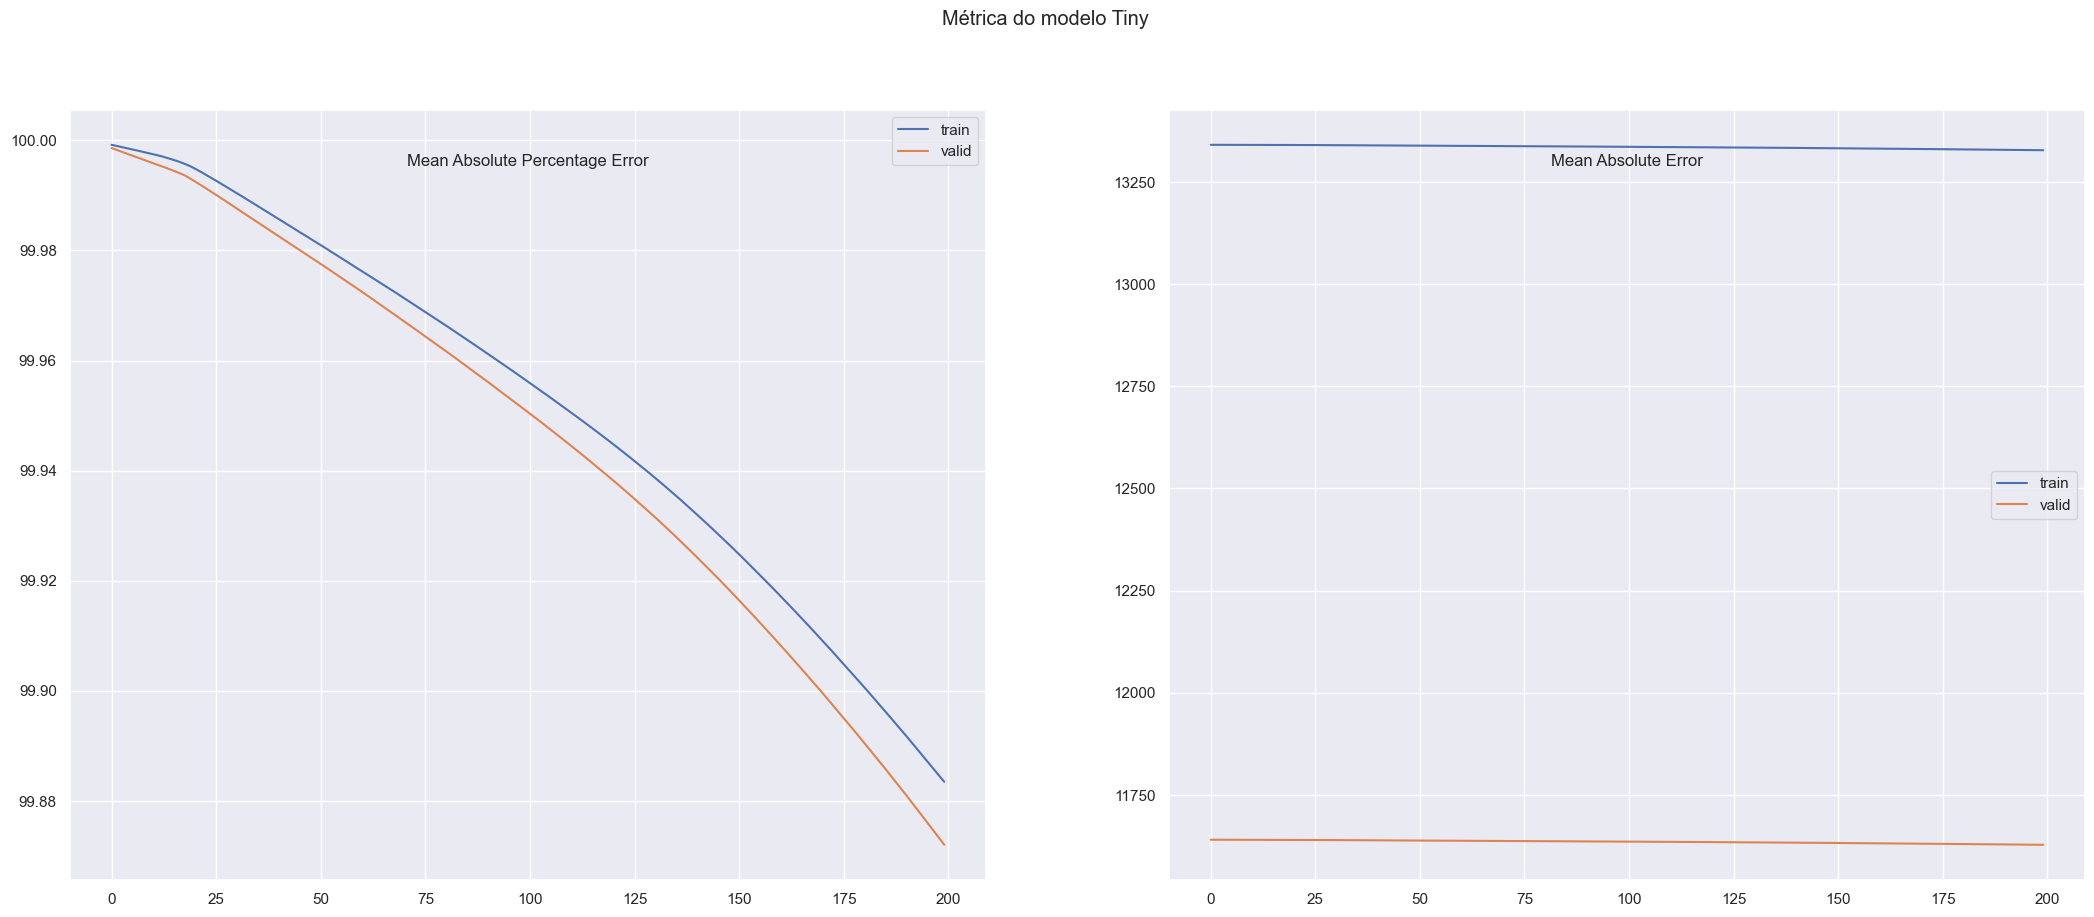

In [26]:
# Imprime os gráficos do MAPE e MAE (Loss e Metric, respectivamente)
plot_historico(history_tiny, 'Métrica do modelo Tiny')